# RPZ assignment: Perceptron Algorithm
 
**Detailed BRUTE upload instructions for this assignment are at the end of this notebook.**

## Introduction
In all the previous labs, we were trying to design a classifier $q(\mathbf{x}):X \rightarrow D$ by using the a priori probabilities $p_K(k)$ and the
probability density functions $p_{X \vert k}(\mathbf{x}\vert k)$. We were minimising
the Bayesian risk or some more complex criterion. This kind of approach is
commonly referred to as [generative](https://en.wikipedia.org/wiki/Generative_model), because we try to estimate the full
probabilistic model of all variables (we try to find the probabilistic model
which “generated” the training samples).

Sometimes, this is however not practical or even possible, e.g. it is not
possible to get enough samples to get a good estimate of $p_{X\vert k}(\mathbf{x}\vert k)$, so 
instead we try to approximate the decision function $q(\mathbf{x})$ directly
without any knowledge of the underlying probability distribution. This
approach is referred to as [discriminative](https://en.wikipedia.org/wiki/Discriminative_model), 
because we are only interested in training the classifier to make correct decisions and we do not care about
the actual probabilistic model.

In the discriminative approach, we define a criterion (emperical risk) $R_{\text{emp}}(q)$ 
which estimates the risk of the classifier using the training set.
Typically, we calculate $R_{\text{emp}}(q)$ as the classification error of the
classifier $q$ on a training set $\mathcal{T}$ and we try to find a classifier $q^∗$ which
minimizes the emperical risk:
\begin{align*} 
   \mathcal{T}  &=\{(\mathbf{x}_i, y_i); \mathbf{x}_i\in R^n, y_i\in\{0,1\}\}_{i=1,\ldots,N} \\
   R_{\text{emp}}(q)  &= \frac{1}{N}\sum_{i=1}^N W(q(\mathbf{x}_i), y_i)\\
   q^* &= \arg\min_q R_{\text{emp}}(q)
\end{align*}

where $W(d, k)$ denotes the loss function (typically the zero-one loss function is
used). Note that in the discriminative task formulation no probability
densities are used. In this lab we will also strictly use bold letters for
vectors and regular font for scalars.

Prepare the notebook environment and import current task file

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from perceptron import *
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

## Part 1: The Perceptron Algorithm

Today's task is to implement the Perceptron algorithm for learning a linear
classifier. In the case of a linear classifier for two classes ($\vert K \vert = 2$),
the discriminative function $q(\mathbf{x}) : X \rightarrow \{0,1\}$ can be expressed as:

<!-- \begin{equation*} -->
$$
q(\mathbf{x}) = \left\{ \begin{array}{l l} 0 & \quad \mathbf{x} \cdot \mathbf{w} + b > 0 \\ 1 & \quad \mathbf{x} \cdot \mathbf{w} + b < 0 \end{array} \right.
$$
<!-- \end{equation*} -->

where $\mathbf{x}=(x_1 , \dots , x_n)^T$, $\mathbf{w} = (w_1, \dots , w_n)^T$, and
$\mathbf{x} \cdot \mathbf{w} = \sum^{n}_{i = 1}{x_i w_i}$ denotes the dot product and the dimensionality of
$X$ is $n$. In geometrical interpretation, the expression $\mathbf{x} \cdot \mathbf{w} + b = 0$ is an
equation of a line (or a hyperplane in higher dimensions) which divides the
space into two subspaces and the value of the discriminative function $q(\mathbf{x})$
represents in which of the two subspaces the vector $\mathbf{x}$ is located.

Thus, the task of finding a linear classifier for two classes can be
formulated as finding parameters $\mathbf{w}$ and $b$ so that the following system of
linear inequalities holds for each item $(\mathbf{x}_i , y_i)$ in the training set:
\begin{align*}
  \mathbf{w} \cdot \mathbf{x}_i + b &> 0 \quad \text{if}\;y_i = 0 \\
  \mathbf{w} \cdot \mathbf{x}_i + b &< 0 \quad \text{if}\;y_i = 1
\end{align*}

The solution of the system exists only if the training data are [linearly
separable](https://en.wikipedia.org/wiki/Linearly_separable), in which case
the solution can be found using the [Perceptron
algorithm](https://en.wikipedia.org/wiki/Perceptron).

The system of inequalities can be equally rewritten as 
\begin{equation*}
\mathbf{v} \cdot \mathbf{z}_i > 0 
\end{equation*}
if we substitute
\begin{align*}
  \mathbf{v} &= [\mathbf{w}; b] \\
  \mathbf{z}_i &= [\mathbf{x}_i; 1] \quad \text{if}\;y_i = 0 \\
  \mathbf{z}_i &= -[\mathbf{x}_i; 1] \quad \text{if}\;y_i = 1
\end{align*}
(try it yourself on a piece of paper - all that happened here is that we made
a 'clever' substitution so that we still have a system of N inequalities, but
now all inequalities have the same format).

Now we can easily describe the algorithm:

>  **The Perceptron Algorithm**
>
> 1. Initialize $\mathbf{v} = 0$
> 2. Find a vector $\mathbf{z}_t$ in the (transformed) training set
>  $\{\mathbf{z}_1, \dots, \mathbf{z}_N\}$ for which the inequality $\mathbf{v} \cdot \mathbf{z}_i > 0$ does not hold.
> 3. Terminate the algorithm if there is no such vector for which the inequality from 2. does not hold, i.e. **all** inequalities are satisfied
> 4. Update the parameters $\mathbf{w}$ and $b$ using the vector $\mathbf{z}_t$ (for which the inequality from 2. does not hold).
>     - The solution is updated as $\mathbf{v} = \mathbf{v} + \mathbf{z}_t$ 
>     - The model parameters $\mathbf{w}$ and $b$ can be simply extracted from $\mathbf{v}$ because $\mathbf{v} = [ \mathbf{w} ; b ]$. 
> 5. Go to step 2.


### Implementation of the Perceptron algorithm
Complete the function `w, b = perceptron(X, y, max_iterations)` which implements
the perceptron algorithm. The function accepts a matrix `X` of `N` training
samples and a vector `y` of training labels. The parameter `max_iterations`
specifies the maximal number of iterations of the algorithm. If a solution is
not found in the given number of iterations the function is expected to
return `w, b = nan, nan` to signal this situation. 

**Hint**: There is more than one valid solution. All valid solutions are able to pass Brute-AE evaluation.

**Hint**: Try to minimalise the number of loops in your code and use NumPy's array operations instead (for the sake of speed).

In [21]:
X = np.array([[1, 1, 2, 2], [1, 3, 5, 6]])
y = np.array([0, 0, 1, 1])
# Run the perceptron algorithm with at most 100 iterations
w, b = perceptron(X, y, 100)
print('your solution may differ\nw: ', w, '\nb: ', b)
# -> your solution may differ
# -> w:  [ 2. -3.] 
# -> b:  9.0
 
X = np.array([[3, 1, 2, 2], [2, 3, 5, 6]])
y = np.array([0, 0, 1, 0])
w, b = perceptron(X, y, 100)
print('w: ', w, '\nb: ', b)
# -> w:  nan 
# -> b:  nan

your solution may differ
w:  [ 2. -3.] 
b:  9.0
w:  nan 
b:  nan


### Test its functionality
Test its functionality on synthetic two-dimensional linearly separable data that **you create**.

- Manually generate the data (for example using [plt.ginput()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.ginput.html))
- Find the linear classifier using the perceptron algorithm (the `perceptron` function you created)
- Visualize the classifier and save the figure as `perceptron_linear.png`. **You are encouraged to create an interesting or funny picture of your own :)**
- Test the algorithm for data, which cannot be linearly separated (e.g. the [XOR problem](https://en.wikipedia.org/wiki/Perceptron#History)). What's happening in this non-separable case?

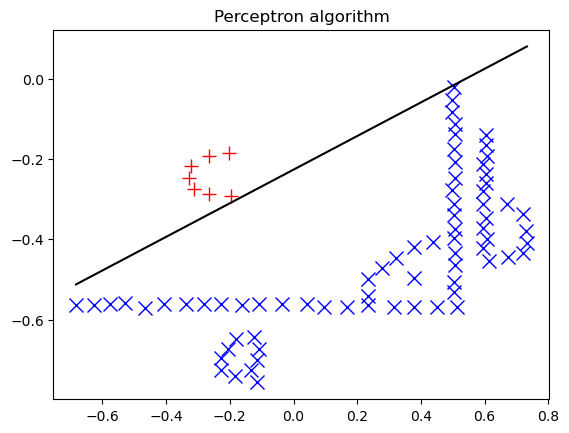

In [22]:
# Load or input the custom X, y data, e.g. 
data = np.load("data_perceptron_separable.npz", allow_pickle=True)
X = data["X_nice"]
y = data["y_nice"]

# Run the perceptron algorithm
w, b = perceptron(X, y, 100)

# Show the data and the resulting linear classifier
plt.figure()
plt.plot(X[0,y==0],X[1,y==0],'bx',ms=10)
plt.plot(X[0,y==1],X[1,y==1],'r+',ms=10)
x_bound =[np.min(X[0]), np.max(X[0])]
xs = np.linspace(x_bound[0], x_bound[1])
ys = -(xs*w[0] +b)/w[1]
plt.plot(xs,ys,'k-')
plt.title('Perceptron algorithm')
plt.savefig('perceptron_linear.png')
plt.show()

In [26]:
# Testing on unseparable data 
data = np.load("data_perceptron_unseparable.npz", allow_pickle=True)
X_un = data["X_nice"]
y_un = data["y_nice"]

# Run the perceptron algorithm
w, b = perceptron(X_un, y_un, 100)
if np.all(np.isnan(w)):
    print('The algorithm did not converge in given iteration limit.')
print(f"w:{w}\nb:{b}")

The algorithm did not converge in given iteration limit.
w:nan
b:nan


## Part 2: Lifting dimensionality of the feature space
As we have seen in the last point of the first task, for some data a linear
discriminative function that would separate the data does not exist.

In order to deal with this problem, we will extend the Perceptron algorithm
so that it learns quadratic discriminant function (see [non-linear perceptron](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/labs/07_perceptron/nelin_perceptron_en.pdf)). We define a mapping function $\phi: X \rightarrow Z$ which projects the training samples
$\mathbf{x} \in X$ (in the last example $X=\mathbb{R}^2$) into a higher-dimensional space $Z$.

In our task, we will consider the discriminative function in the form:
$$
q'(\mathbf{x}) = w_1x_1 + w_2x_2 + w_3x_1^2 + w_4x_1x_2 + w_5x_2^2 + b
$$
By comparing this discriminative function $q'(\mathbf{x})$ to the linear case $q(\mathbf{x})$, we can derive the formula for 
the feature vector $\mathbf{z} \in Z$ in the lifted space:
$$
\mathbf{z} = \phi(\mathbf{x})= (x_1, x_2, x_1^2, x_1x_2, x_2^2)^T
$$

The entire extension of the Perceptron algorithm then goes as follows:

- Transform the training data into the lifted space $Z$ using the mapping function $\phi(\cdot)$
- Run the standard linear Perceptron algorithm in the lifted space $Z$
- Substitute found parameters $w_1, \dotsc, w_5$ and $b$ into the quadratic discriminative function

**Hint**: If the Perceptron algorithm does not converge for the lifted features, try increasing the number ``max_iterations``

### Implementation the lifting function

Complete the function `Z = lift_dimension(X)` which implements the mapping $\phi(\cdot)$ of the feature space into the 5-dimensional space

In [29]:
X = np.array([[1, 0, 2], [3, 5, 1]])
Z = lift_dimension(X)

np.testing.assert_equal(Z, 
                        np.array([[1 ,    0,     2],
                                  [3 ,    5,     1],
                                  [1 ,    0,     4],
                                  [3 ,    0,     2],
                                  [9 ,   25,     1]]),
                        "The lifting is incorrect!")

# Try lifting the unseparable data
Z_un = lift_dimension(X_un)

# Run the Perceptron algorithm with at most 1000 iterations on lifted data
w_un, b_un = perceptron(Z_un, y_un, 1000)
if np.all(np.isnan(w_un)):
    print('The algorithm did not converge in given iteration limit.')
print(f"w_un:{w_un}\nb_un:{b_un}")

w_un:[-0.15520367 -0.3590178   2.53899332  0.53323432  3.4592346 ]
b_un:-1.0


### Implementation the quadratic discriminative function
Complete the template function `Y = classif_quadrat_perc(tst, model)` which classifies the testing data using the quadratic discriminative function $q'(\mathbf{x})$

The function is called automatically by the visualisation function `pboundary` and
its role is to classify the supplied testing data tst (in our case 2D data)
to two classes (i.e. the elements of the output Y are either 0 or 1).
Parameters of the classifier are stored in the `model` parameter, which is the
same one as the one passed to the `pboundary` function. In our case, the model
will contain parameters of the current state of the quadratic classifier - `w` and `b`

### Test its functionality
Test functionality of the two functions on synthetic two-dimensional non-separable data that **you create**.

- Manually generate some linearly non-separable data (for example using [plt.ginput()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.ginput.html))
- Find the quadratic classifier using the perceptron algorithm
- Visualize the classifier using the `pboundary` function and save the figure
  into `perceptron_quadratic.png` (again use your imagination to create some interesting picture ;-))

w:[-0.15520367 -0.3590178   2.53899332  0.53323432  3.4592346 ]
b:-1.0


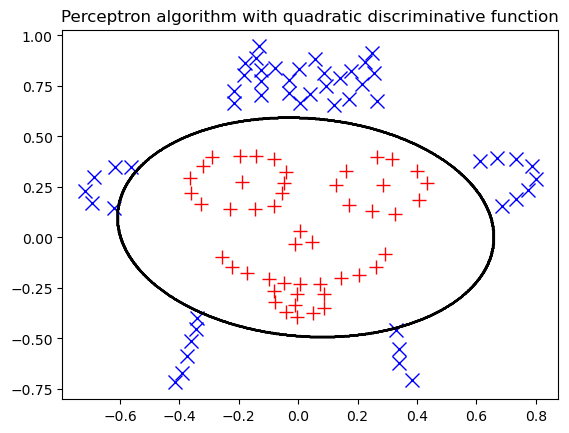

In [33]:
# Load or input the custom X, y data, e.g. 
X = X_un
y = y_un

# lift the input data to Z
Z = lift_dimension(X)

# Run the perceptron algorithm
w, b = perceptron(Z, y, 1000)
if np.all(np.isnan(w)):
    print('The algorithm did not converge in given iteration limit.')
print(f"w:{w}\nb:{b}")

# Show the data and the resulting classifier
model = {'w': w, 'b': b}
pboundary(X, y, model)
plt.title('Perceptron algorithm with quadratic discriminative function')
plt.savefig('perceptron_quadratic.png')
plt.show()

## Submission to the BRUTE Upload System

To fulfill this assignment, you need to submit these files (all packed in one ''.zip'' file) into the __[upload system](https://cw.felk.cvut.cz/brute/)__:

  - **`perceptron.ipynb`** - a script for data initialisation, calling of the implemented functions and plotting of their results (for your convenience, will not be checked).
  - **`perceptron.py`** - containing the following implemented methods:
    - **`perceptron `** - a function which implements the perceptron algorithm, section 1.2
    - **`lift_dimension `** - a mapping function which lifts the dimensionality of the feature space, section 1.YY
    - **`classif_quadrat_perc `** - a quadratic discriminative function, section 1.ZZ
  - **`perceptron_linear.png`** and **`perceptron_quadratic.png`** - images specified in the tasks

When preparing a zip file for the upload system, **do not include any directories**, the files have to be in the zip file root.

## Bonus Tasks
Choose one or both of the following bonus tasks.


### Kozinec's Algorithm
Implement the Kozinec's algorithm for learning of a linear discriminant function. For a set of points $\{x^j, j \in J\}$, the Kozinec's algorithm finds vector 
$\alpha$, which satisfies a set of linear inequations
\begin{equation*}
\langle\alpha, x^j\rangle > 0,  \quad j \in J
\end{equation*}
I.e. the problem is the same as in the Perceptron. The Kozinec's algorithm creates a sequence of vectors $\alpha_1, \alpha_2, \ldots, \alpha_t, \alpha_{t+1}, \ldots$ in the following way.

**The algorithm**: Vector $\alpha_1$ is any vector from the convex hull of the set $\{x^j, j \in J\}$, e.g. one of the vectors $\{x^j, j \in J\}$. If the vector 
$\alpha_t$ has already been computed, $\alpha_{t+1}$ is obtained using the following rules:
1. A misclassified vector $\{x^j, j \in J\}$ is sought, which satisfies $\langle\alpha_t, x^j\rangle \leq 0$
2. If such $x_j$ does not exist, the solution to the task has been found, and $\alpha_{t+1}$ equals to $\alpha_t$.
3. If such $x_j$ does exist, it will be denoted as $x_t$. Vector $\alpha_{t+1}$ then lies on a line passing through $\alpha_t$ and $x_t$. From all the points on the
   line, $\alpha_{t+1}$ is the closest one to the origin of the coordinate system. In other words
   \begin{equation*}
      \alpha_{t+1} = (1 - k) \alpha_t + k x_t
   \end{equation*}
   where
   \begin{equation*}
      k = \arg\min_k |(1 - k) \alpha_t + k x_t|.
   \end{equation*}

**Find $k$ analytically, do not use numerical methods.**

**Output**: Identical to the output to the task in section _Part 1: The Perceptron Algorithm_.

**Hint**: The Kozinec algorithm is described in Chapter 5 of _Michail I. Schlesinger, Vaclav Hlavac. Ten Lectures on Statistical and Structural Pattern Recognition. Kluwer 2002_


### Multi-class Perceptron
Implement multi-class perceptron learning algorithm. The mutli-class classifier is formulated as
\begin{equation*}
    f(\mathbf{x}) = \arg\max_{y\in\cal Y}\,\bigl(\mathbf{w}_y^\top\mathbf{x}+b_y\bigr),
\end{equation*}
where $\cal W=\bigl\{(\mathbf{w}_y, b_y)\mid y\in\cal Y\bigr\}$ is a set of classifier parameters and $\cal Y$ is a set of classes.

The training algorithm was not presented at the lectures, but it is simple and elegant as follows:
1. Compute class means
\begin{equation*}
    \boldsymbol{\mu}_y = \frac{1}{|\cal X^y|}\sum_{i\in\cal X^y} \mathbf{x}^y_i,
\end{equation*}
where $\cal X^y$ are indices of training set samples belonging to class $y$.
2. Set $\mathbf{w}_y = \boldsymbol{\mu}_y$ and $b_y = 0$ for all $y\in \cal Y$.
3. From the training set $\cal T=\{(\mathbf{x}^1,y^1),\ldots,(\mathbf{x}^m,y^m)\}$ choose $(\mathbf{x}^t,y^t)$ subject to $y^t \neq \hat{y}\:$, where 
\begin{equation*}
    \hat{y}= \arg\max_{y\in\cal Y}  \,\bigl(\mathbf{w}_y^\top\mathbf{x}^t + b_y \bigr)
\end{equation*}
(i.e. arbitrary misclassified sample).
4. Terminate if such a sample is not found. Parameters $\cal W=\{(\mathbf{w}_y,b_y) \mid y\in\cal Y\}$ define a classificatior with zero training error.
5. Otherwise let $\hat{y}$ be the classification $\mathbf{x}_t$ using current classifier. Modify classifier parameters $\cal W$ as follows
   \begin{align*}
   \mathbf{w}_{y^t}     & := \mathbf{w}_{y^t} + \mathbf{x}^t\,, \hspace{2em} &  \mathbf{w}_{\hat{y}} & :=  \mathbf{w}_{\hat{y}} - \mathbf{x}^t\,,\\
   b_{y^t}      & := b_{y^t} + 1\,, \hspace{2em} &  b_{\hat{y}} & := b_{\hat{y}} - 1\,.\\
   \end{align*}
6. Continue with step 3.

**Plot the multi-class decision boundaries.**